In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import numpy as np
import PIL.Image as Image
import torchvision.models as models
from pathlib import Path
from collections import deque
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
feature_extractor = nn.Sequential(
    base_model.features,                # backbone
    nn.AdaptiveAvgPool2d((1, 1)),       # global average pooling
    nn.Flatten()                        # chuyển [1280,1,1] -> [1280]
).eval()                                # chỉ inference, không học
for p in feature_extractor.parameters():
    p.requires_grad_(False)             # khóa trọng số (frozen)

# 2. Biến đổi ảnh (chuẩn hóa theo ImageNet)
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [3]:
def extract_feature(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0)  # [1,3,224,224]
    with torch.no_grad():
        feat = feature_extractor(x)
        feat = nn.functional.normalize(feat, p=2, dim=1)  # L2 normalize
    return feat.squeeze(0)  # [1280]

# 4. Đọc tất cả ảnh GOOD và tạo tập đặc trưng
data_dir = Path("./data/image/GOOD/")
  # thư mục chứa ảnh GOOD
features = []
for img_path in data_dir.glob("*.*"):
    feat = extract_feature(img_path)
    features.append(feat)
features = torch.stack(features)  # [N,1280]



In [4]:
def extract_feature(image_path, show=True):
    img = Image.open(image_path).convert("RGB")

    # Ảnh sau transform (resize + crop 224×224)
    x = transform(img)
    img_transformed = T.ToPILImage()(x) # chuyển tensor -> PIL Image để hiển thị
    print("Ảnh gốc:", img.size)        # (W, H)
    print("Ảnh sau transform:", x.shape)  # (3, 224, 224)
    # Hiển thị song song ảnh gốc và ảnh sau transform
    if show:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Ảnh gốc ({img.size[0]}x{img.size[1]})")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_transformed)
        plt.title("Ảnh sau transform (224x224)")
        plt.axis("off")
        plt.show()

    # Đưa ảnh qua mạng
    x = x.unsqueeze(0)  # [1,3,224,224]
    with torch.no_grad():
        feat = feature_extractor(x)
        feat = nn.functional.normalize(feat, p=2, dim=1)  # L2 normalize
    return feat.squeeze(0)  # [1280]


Ảnh gốc: (2048, 1536)
Ảnh sau transform: torch.Size([3, 224, 224])


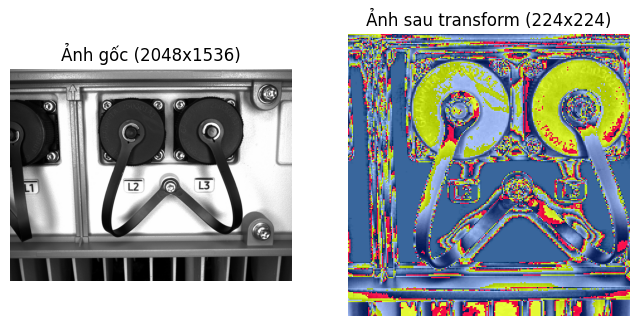

In [5]:
img_path = "./data/image/GOOD/OPR_00_32_59_6.jpg"
feat = extract_feature(img_path, show=True)

In [6]:
# 5. Tính prototype (mean vector)
mu = features.mean(dim=0)
mu = nn.functional.normalize(mu, p=2, dim=0)  # normalize prototype

# 6. Tính similarity của từng ảnh GOOD với prototype
sims = features @ mu  # [N] cosine similarity vì đã normalize

# 7. Tính ngưỡng threshold theo percentile (vd: 5%)
p = 5  # 5%
T_val = np.percentile(sims.numpy(), p)
torch.save({
    "prototype": mu,
    "threshold": T_val,
}, "model_edge_init.pth")

print(f"Số ảnh GOOD: {len(features)}")
print(f"Kích thước vector đặc trưng: {features.shape[1]}")
print(f"Cosine similarity trung bình: {sims.mean():.4f}")
print(f"Ngưỡng (percentile {p}%): {T_val:.4f}")

Số ảnh GOOD: 100
Kích thước vector đặc trưng: 1280
Cosine similarity trung bình: 0.9564
Ngưỡng (percentile 5%): 0.9237


0it [00:00, ?it/s]

Ảnh gốc: (2048, 1536)
Ảnh sau transform: torch.Size([3, 224, 224])


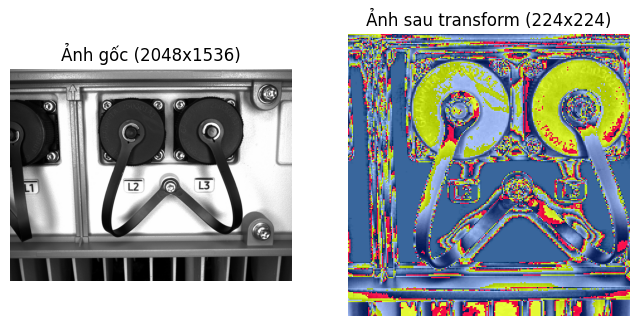

1it [00:01,  1.23s/it]

Ảnh: OPR_00_32_59_6.jpg, similarity=0.9721 → GOOD
Ảnh gốc: (2048, 1536)
Ảnh sau transform: torch.Size([3, 224, 224])


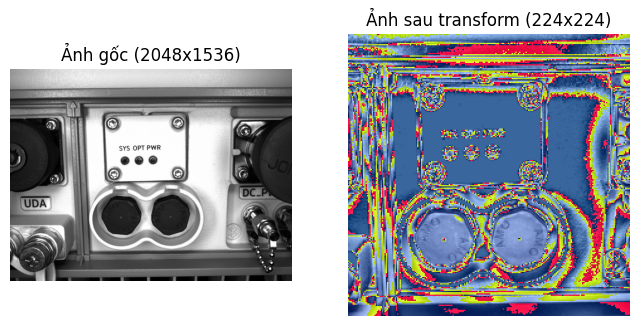

2it [00:02,  1.23s/it]

Ảnh: OPR_01_02_24_3.jpg, similarity=0.7535 → NG


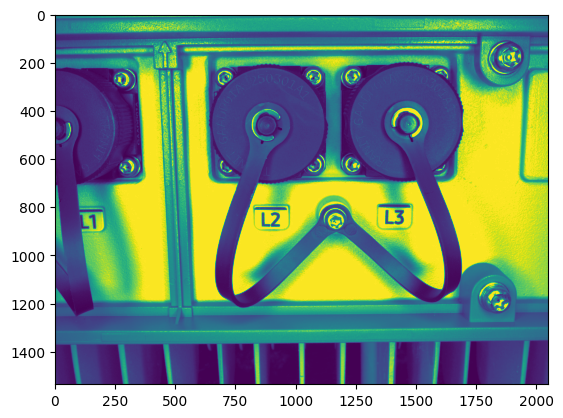

In [8]:
# 1. Load prototype và ngưỡng ban đầu
checkpoint = torch.load("model_edge_init.pth")
mu = checkpoint["prototype"]
T_val = checkpoint["threshold"]

# 2. Tạo memory bank để cập nhật ngưỡng linh hoạt (chỉ lưu GOOD)
memory_bank = deque(maxlen=300)  # lưu vector GOOD gần nhất
alpha = 0.05   # tốc độ học
p = 5          # percentile để tính threshold mới

def check_image_online(image_path, mu, T_val, memory_bank, alpha=0.05, p=5):
    """Kiểm tra ảnh mới, trả về GOOD/NG và cập nhật prototype nếu cần"""
    z = extract_feature(image_path)           # [1280]
    sim = torch.dot(z, mu).item()             # cosine similarity
    
    # Quyết định GOOD/NG
    is_good = sim >= T_val
    print(f"Ảnh: {image_path.name}, similarity={sim:.4f} → {'GOOD' if is_good else 'NG'}")
    
    # Nếu GOOD → học thêm
    if is_good:
        # Cập nhật prototype bằng EMA
        mu = nn.functional.normalize((1 - alpha) * mu + alpha * z, p=2, dim=0)
        
        # Thêm vào memory bank
        memory_bank.append(z.detach())
        
        # Cập nhật ngưỡng (threshold) từ percentile mới
        sims = torch.stack(list(memory_bank)) @ mu
        T_val = np.percentile(sims.numpy(), p)
    
    # Trả về kết quả + prototype mới + threshold mới
    return is_good, sim, mu, T_val, memory_bank

# --- Ví dụ kiểm tra ---
test_dir = Path("./data/image/NG/")
for img_path in tqdm(test_dir.glob("*.*")):
    is_good, sim, mu, T_val, memory_bank = check_image_online(
        img_path, mu, T_val, memory_bank, alpha, p
    )

# Sau khi chạy xong có thể lưu prototype mới
torch.save({"prototype": mu, "threshold": T_val}, "model_edge_updated.pth")
img_file_path = './data/image/NG/OPR_01_02_24_3.jpg'
img_file_path1 = './data/image/NG/OPR_00_32_59_6.jpg'
img = Image.open(img_file_path1)
plt.imshow(img)
plt.show()


In [9]:
# --- Khởi tạo feature extractor ---
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
feature_extractor = nn.Sequential(
    base_model.features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
).eval()

# --- Xuất sang ONNX ---
dummy_input = torch.randn(1, 3, 224, 224)  # input giả
torch.onnx.export(
    feature_extractor,
    dummy_input,
    "mobilenetv2_feature.onnx",
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch"}, "embedding": {0: "batch"}},
    opset_version=11
)

print("Đã xuất MobileNetV2 sang mobilenetv2_feature.onnx")

Đã xuất MobileNetV2 sang mobilenetv2_feature.onnx
